# Helmholtz with Perfectly Matched Layer (PML)

Disclaimer: The following code is for you to get a feeling regarding using PML. It was improvised during the summer school and therefore I did not have time to throughly test it. From experience, it seems to behave close enough to PML to give you an idea, but without a proper validation, it is not suitable for simulations and I do not claim it is correct. 

In this code we will try the cartesian PML that was introduced in Carlos' lecture. In other words, we will implement our PML as the tensor product of the 1d PML he presented in his lecture. This code is 2d, and therefore we will be considering a box.

In [1]:
import numpy as np
import math
from typing import Tuple
from easyFEMpkg.mesh import build_square_with_pml
from easyFEMpkg.plotting import mesh_and_solution_side_by_side, draw_inner_box
from easyFEMpkg.pml import CartesianPML, assemble_helmholtz_pml
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import matplotlib.tri as mtri


## Parameters

In [10]:
k = 10                    # wavenumber
inner_box = (-1.0, 1.0, -1.0, 1.0)
pml_thickness = 0.2       # each side; outer box is [-1-L, 1+L]^2
max_area = 0.005 #for the mesh refinement

def rhs(x, y):
    return math.exp(-20**2*((x-0.2)*(x-0.2)+y*y))           # no body force (set to 1.0 to test)

# Homogeneous Dirichlet on the OUTER boundary of the PML box
def g_outer(x, y):
    return 0.0


## Build mesh (inner + PML outer box)

In [11]:
p, t, bnd, elem_region, outer_bnd = build_square_with_pml(inner_box=inner_box,
                                                           pml_thickness=pml_thickness,
                                                           max_area=max_area,
                                                           return_tags=True)
print('nodes:', len(p), 'triangles:', len(t), 'boundary edges:', len(bnd))
print('outer boundary edges:', len(outer_bnd), 'PML elements:', int((elem_region==1).sum()))

nodes: 985 triangles: 1856 boundary edges: 112
outer boundary edges: 112 PML elements: 559


## Define PML coefficients and assemble

In [12]:
xi, xa, yi, ya = inner_box
outer_xmin, outer_xmax = xi - pml_thickness, xa + pml_thickness
outer_ymin, outer_ymax = yi - pml_thickness, ya + pml_thickness

pml = CartesianPML(xmin=outer_xmin, xmax=outer_xmax,
                   ymin=outer_ymin, ymax=outer_ymax,
                   Lx=pml_thickness, Ly=pml_thickness,
                   omega=k, m=2, sigma_max_x=25.0, sigma_max_y=25.0)
A_B_func = pml.A_B_at

# Assemble on full mesh; impose Dirichlet only on OUTER boundary
S, b = assemble_helmholtz_pml(p, t, outer_bnd, k, A_B_func,
                               rhs=rhs,
                               dirichlet_outer=g_outer,
                               mass='consistent')
u = spsolve(S, b)
u_real = np.real(u)
u_imag = np.imag(u)
u_abs  = np.abs(u)

## Plot results

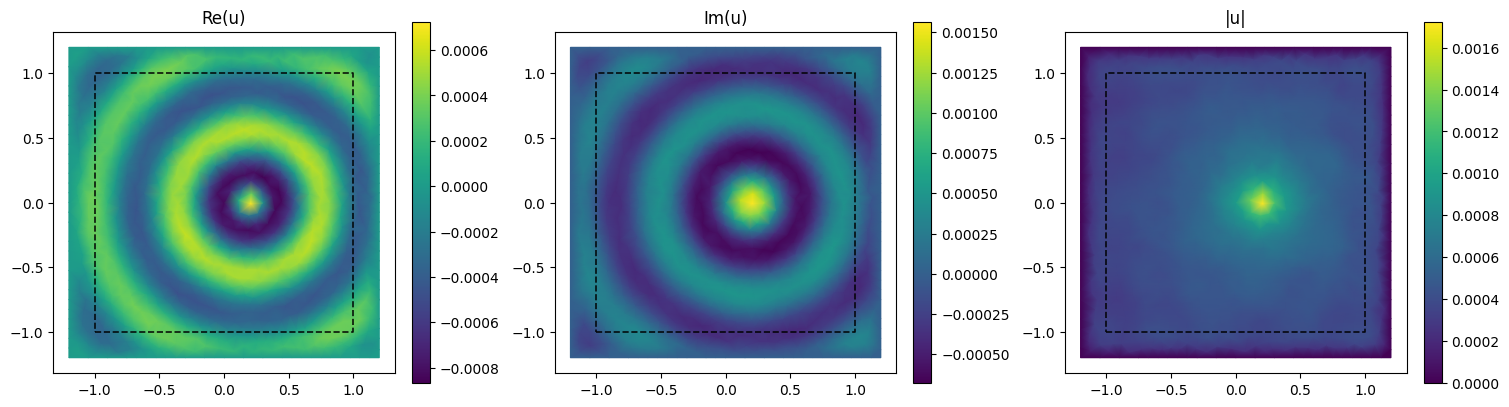

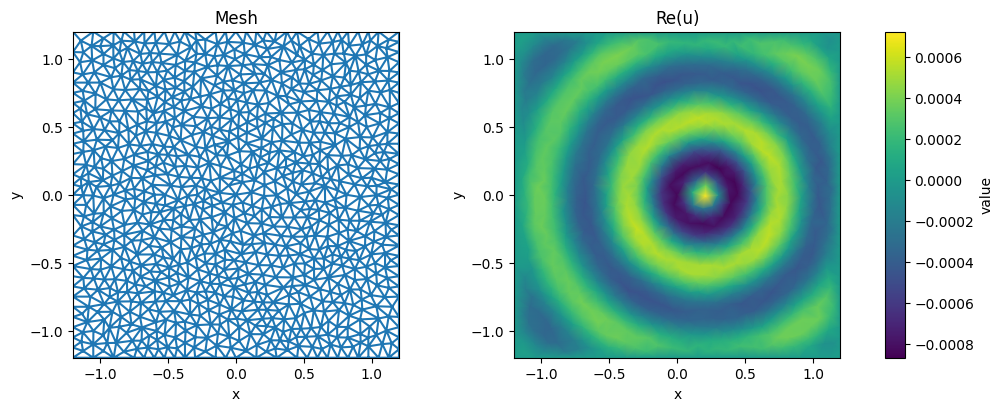

In [13]:
tri = mtri.Triangulation(p[:,0], p[:,1], t)
fig, axes = plt.subplots(1,3, figsize=(15,4), constrained_layout=True)
for ax, data, title in zip(axes, [u_real, u_imag, u_abs], ['Re(u)', 'Im(u)', '|u|']):
    pc = ax.tripcolor(tri, data, shading='gouraud')
    ax.set_aspect('equal'); ax.set_title(title)
    draw_inner_box(ax, inner_box)  # overlay inner box
    fig.colorbar(pc, ax=ax)
plt.show()

# Side-by-side mesh and |u|
mesh_and_solution_side_by_side(p, t, u_real, title='Re(u)')